In [11]:
import model_utils

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
use_gpu

False

In [3]:
DATA_DIR = 'E:/catsanddogs - Copy/PetImages/'
sz = 224
batch_size = 20

In [4]:
os.listdir(DATA_DIR)

['train', 'valid']

In [5]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [6]:
os.listdir(trn_dir)

['Cat', 'Dog']

In [7]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['E:/catsanddogs - Copy/PetImages/train\\Cat\\0.jpg',
 'E:/catsanddogs - Copy/PetImages/train\\Cat\\1.jpg',
 'E:/catsanddogs - Copy/PetImages/train\\Cat\\10.jpg',
 'E:/catsanddogs - Copy/PetImages/train\\Cat\\100.jpg',
 'E:/catsanddogs - Copy/PetImages/train\\Cat\\1000.jpg']

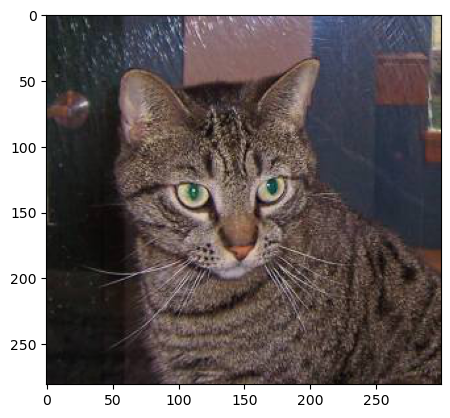

In [8]:
img = plt.imread(trn_fnames[1])
plt.imshow(img);

In [9]:
train_ds = datasets.ImageFolder(trn_dir)

In [10]:
train_ds.classes


['Cat', 'Dog']

In [11]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [12]:
# len(train_ds)
len(train_ds)


2838

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=8)


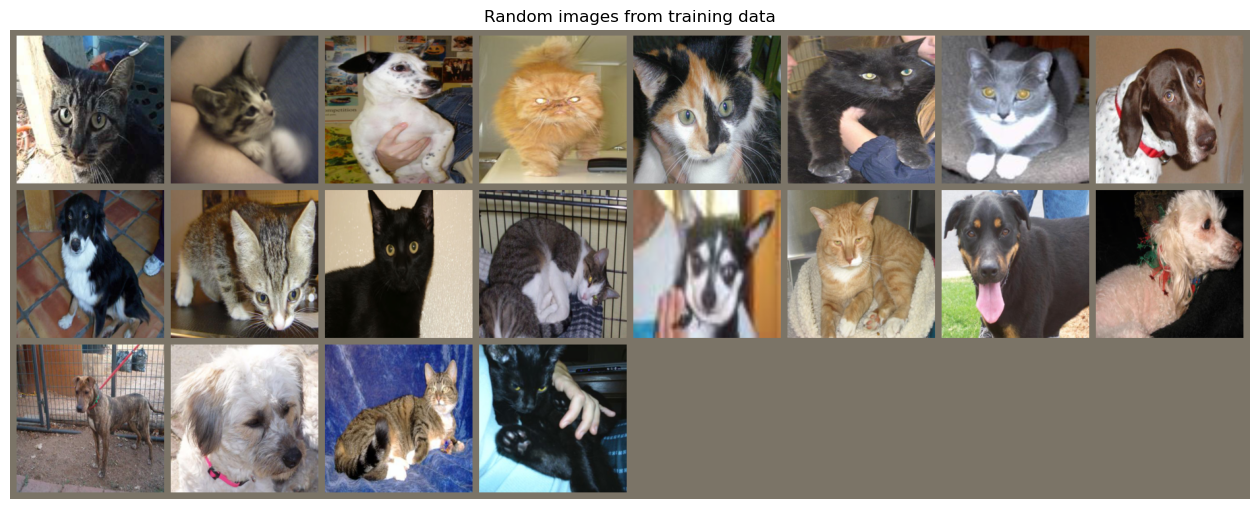

In [15]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=10)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')


In [34]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128 , 264, kernel_size=5, padding=2),
            nn.BatchNorm2d(264),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(264, 512, kernel_size=5, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=5, padding=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(1 * 1 * 1024, 1024)
        self.fc1 = nn.Linear(1024 ,512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512 , 512)
        self.fc4 = nn.Linear(512 , 2)
        # self.fc = nn.Linear(7 * 7 * 256 , 10)
        # self.fc1 = nn.Linear(10, 2)
      

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out =self.conv3(out)
        out= self.conv4(out)
        out =self.conv5(out)
        out =self.conv6(out)
        out =self.conv7(out)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = F.relu(self.fc(out))
        out= F.relu(self.fc1(out))
        out =F.relu(self.fc2(out))
        out =F.relu(self.fc3(out))

        out = self.fc4(out)
        # out =self.fc1(out)
        return out


In [35]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)


In [37]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))


Epoch [ 1/ 5], Step [ 50/141], Loss: 0.7208
Epoch [ 1/ 5], Step [100/141], Loss: 0.6526
Epoch [ 2/ 5], Step [ 50/141], Loss: 0.5184
Epoch [ 2/ 5], Step [100/141], Loss: 0.4644
Epoch [ 3/ 5], Step [ 50/141], Loss: 0.4328
Epoch [ 3/ 5], Step [100/141], Loss: 0.6423
Epoch [ 4/ 5], Step [ 50/141], Loss: 0.5930
Epoch [ 4/ 5], Step [100/141], Loss: 0.3439
Epoch [ 5/ 5], Step [ 50/141], Loss: 0.6356
Epoch [ 5/ 5], Step [100/141], Loss: 0.6196


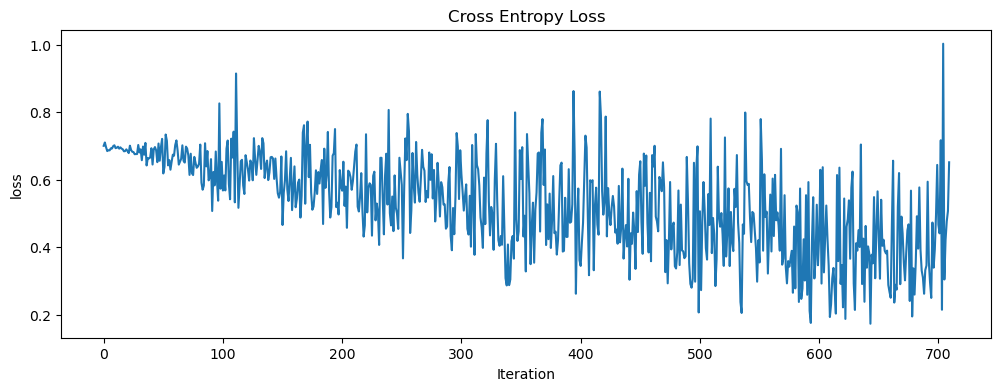

In [38]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

In [39]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    

In [40]:
evaluate_model(model, valid_dl, device)

accuracy: 72.24


In [33]:
evaluate_model(model, train_dl, device)


KeyboardInterrupt: 

In [ ]:
visualize_model(model, train_dl, device)


In [ ]:
plot_errors(model, valid_dl, device)
